# Research on Employee Attrition (Roman Poletukhin, MIPT)


## Task statement

### General

As I was asked to reveal the factors that lead to employee attrition and was given a 'carte blanche' in deciding which strategy to use in this research, I came up with the following scheme:

Initially I regard the task set as a problem of binary classification as all employees of the company N fall into one of 2 groups: whether the particular employee has attrition (`Attrition` = `Yes`) or not (`Attrition` = `No`).
Firstly, I use 4 algorithms of supervised machine learning to solve this problem of binary classification with the data given in the task.

Secondly, I evaluate each model with several ML-metrics to conclude whether the model classifies employees correctly.
Next, I analyze the weight that each parameter (e.g. `Age` or `DistanceFromHome`) has in each model. Eventually, as the bigger weight indicates the bigger impact in making an employee attrited, I have a sequence of attrition factors in descending (by significance) order.

### Choice of algorithms


I divided the supervised classication algorithms chosen into 3 groups:

1) Linear model: $\textbf{Ridge Classifier}$ - having target variables `Attrition` equal to `+1` or `-1` builds a `Ridge()` model (which is a regression model) to predict our target variable, compares the predicted value with `0`. The loss function:  $Loss = \sum_{i=1}^{n}(x_i-y_i)^2 + \lambda \sum_{i=1}^n w_i^{2}$, which is a sum of MSE and L2 penalty.

2) (Heuristic) ensemble model: for this approach I choose two ensemble algorithms ($\textbf{Random Forest Classifier}$ and $\textbf{Gradient Boosting Classifier}$). Since I discovered that the results and accuracies are quite similar, I decided to present a single prediction from the class of ensemble models (presented by RF and GB) rather than a prediction of each RF and GB.

3) 'Advanced' and 'not-so-classic' ensemble model: I choose $\textbf{Cat Boost Classifier}$, an open-source ensemble model developed by Yandex that uses oblivious decision trees.


## Data prepossessing

### Import of the required libraries, classes and methods

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
# for dividing the data into train & test
from sklearn.model_selection import train_test_split
# for scaling of data
from sklearn.preprocessing import StandardScaler
# for the linear modelling
from sklearn.linear_model import RidgeClassifier
# for the modelling with emsemble models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# for the modelling with oblivious decision trees (open-source ensemble model from Yandex)
from catboost import CatBoostClassifier
# for creating a pipeline
from sklearn.pipeline import Pipeline
# for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
# for visualization 
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot

### Loading of given data from the Excel file `Company_HR_Employees`

In [2]:
# initializing a pandas dataframe with data
df = pd.read_excel('Company_HR_Employees.xlsx')

### Data inspection

In [3]:
# let's see what we got here
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,2068,2,...,1,80,0,6,3,4,4,3,1,2
1,49,No,Travel_Frequently,1023,Sales,2,3,Medical,2065,4,...,4,80,0,17,3,2,9,6,0,8
2,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2064,2,...,2,80,1,6,0,3,6,2,0,3
3,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,2062,4,...,1,80,1,9,5,3,7,7,1,7
4,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,2061,3,...,3,80,1,17,3,3,5,2,0,3


In [4]:
# let's check if we have any NaNs
df.isnull().values.any()

False

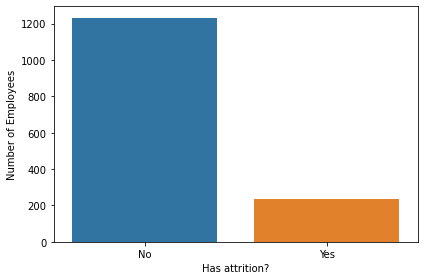

In [5]:
#let's look at target feature to see if it's binary and to simply look at the distribution of answers
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Attrition'])
plt.xlabel('Has attrition?')
plt.ylabel('Number of Employees')
plt.tight_layout()

### Target feature selection

In [6]:
# change values of target feature to -1 and +1
df['Attrition'].replace('Yes', 1, inplace=True)
df['Attrition'].replace('No', -1, inplace=True)

#save the series with the target feature
y = df['Attrition']

### Deleting several features in `df`

In [7]:
# delete those columns where value is identical to all - these columns (obviously) won't help us in classification
df.drop(columns = df.columns[df.nunique() <= 1], inplace=True)

# don't really need it either
df.drop(columns='EmployeeNumber', inplace=True)

# delete the series with the target value
df.drop(columns='Attrition', inplace=True)

In [50]:
# let's look at the df now
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,Travel_Rarely,628,Research & Development,8,3,Medical,2,Male,82,...,3,1,0,6,3,4,4,3,1,2
1,49,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,63,...,3,4,0,17,3,2,9,6,0,8
2,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87,...,4,2,1,6,0,3,6,2,0,3
3,39,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,42,...,3,1,1,9,5,3,7,7,1,7
4,36,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,41,...,3,3,1,17,3,3,5,2,0,3


### Convert categorical variables in df into dummy/indicator variables

In [51]:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,34,628,8,3,2,82,4,2,3,4404,...,0,0,0,0,0,0,1,0,1,0
1,49,1023,2,3,4,63,2,2,2,5390,...,0,0,0,1,0,0,1,0,1,0
2,27,155,4,3,2,87,4,2,2,6142,...,1,0,0,0,0,0,1,0,0,1
3,39,613,6,1,4,42,2,3,1,9991,...,0,0,0,0,0,0,1,0,1,0
4,36,884,23,2,3,41,4,2,4,2571,...,0,0,0,0,0,0,1,0,1,0


### Finding correlated features

In [10]:
correlation_matrix = df_dummy.corr()
for delim in np.linspace(0.1, 1., 10):
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > delim:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    print("Num of pairs, which correlation is over","%.2f" % delim, ":", len(correlated_features))

Num of pairs, which correlation is over 0.10 : 34
Num of pairs, which correlation is over 0.20 : 32
Num of pairs, which correlation is over 0.30 : 25
Num of pairs, which correlation is over 0.40 : 22
Num of pairs, which correlation is over 0.50 : 19
Num of pairs, which correlation is over 0.60 : 16
Num of pairs, which correlation is over 0.70 : 11
Num of pairs, which correlation is over 0.80 : 6
Num of pairs, which correlation is over 0.90 : 5
Num of pairs, which correlation is over 1.00 : 0


Therefore, I see that we have correlated features, this is where Ridge Classifier will help us (as it has L2 penalty $\lambda \sum_{i=1}^n w_i^{2}$ in its $Loss$ function added against highly correlated independent variables).

In [11]:
# Lastly, let's take all the values from the DataFrame to an array
X = df_dummy.values

## Implementation

### Evaluation of accuracy

Firstly, let's create a function we'll use to evaluate the results of each prediction. As we have a classification problem, we'll look at the classic metrics: Accuracy and F1-score.

In [12]:
def eval_acc(model, test_features, test_labels, mode=0):
    acc = accuracy_score(test_labels, model.predict(test_features))
    f1 = f1_score(test_labels, model.predict(test_features), average='weighted')
    if mode == 1:
        print("Accuracy:", acc)
        print("f1-score:", f1)
        print(confusion_matrix(test_labels, model.predict(test_features)))
        print(classification_report(test_labels, model.predict(test_features)))
        scikitplot.metrics.plot_roc(test_labels, model.predict_proba(test_features))
    return acc, f1

### Linear model: Ridge Classifier

In [13]:
# values of accuracy_score
results_linear_acc = []
# values of f1_score
results_linear_f1 = []
# different test_sizes: 5%, 10% ... 50%
test_sizes = np.arange(0.05, 0.51, 0.05)
for test_size in test_sizes:
    # we split the data (with stratify since our classes are not balanced)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    # after splitting the dataset we apply scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # use the method
    ridge_classifier = RidgeClassifier()
    ridge_classifier.fit(X_train, y_train)
    predictions = ridge_classifier.predict(X_test)
    # add values to score arrays
    results_linear_acc.append(eval_acc(ridge_classifier, X_test, y_test)[0])
    results_linear_f1.append(eval_acc(ridge_classifier, X_test, y_test)[1])

In [14]:
# let's find the mean accuracy and f1-score and look at extended parameters of last launch
print('=' * 50)
print('Mean accuracy for Ridge Classifier is %.2f' % np.mean(results_linear_acc))
print('Mean F1-score for Ridge Classifier is %.2f' % np.mean(results_linear_f1))
print('=' * 50)
print(classification_report(y_test, predictions))

Mean accuracy for Ridge Classifier is 0.87
Mean F1-score for Ridge Classifier is 0.84
              precision    recall  f1-score   support

          -1       0.87      0.99      0.92       616
           1       0.75      0.23      0.35       119

    accuracy                           0.86       735
   macro avg       0.81      0.61      0.64       735
weighted avg       0.85      0.86      0.83       735



The results are pretty good, now let's look at each feature and its importance.

### Ridge Classifier Results

In [52]:
# here we have weights for this model
weights = ridge_classifier.coef_[0]

In [16]:
# not the smartest way, but here's the list with indexes by their importance (in descending order)
indexes_list = []
weights_mask = weights.copy()
for i in range(len(df_dummy.columns)):
    # we take the No. of the biggest current weight and add it to the end of the list
    indexes_list.append(np.argmax(weights_mask))
    # we 'discard' the already-inspected biggest weight by giving it a value << lowest
    weights_mask[np.argmax(weights_mask)] = -10

In [17]:
# create a list of initial columns by their indexes
ordered_column_list = []
columns_list = list(df_dummy.columns)
for i in range(len(columns_list)):
    ordered_column_list.append(columns_list[int(indexes_list[i])])
    
#initializing a dataframe

linear_factors = pd.DataFrame(data={'Factor': ordered_column_list,
                                    'RC Importance': -np.sort(-weights)})

In [18]:
linear_factors

,Factor,RC Importance
0,JobRole_Human Resources,2.205836e-01
1,OverTime_Yes,1.853469e-01
2,BusinessTravel_Travel_Frequently,1.657436e-01
3,EducationField_Technical Degree,1.512960e-01
4,JobRole_Sales Representative,1.483671e-01
5,JobRole_Laboratory Technician,1.439026e-01
6,EducationField_Human Resources,1.082171e-01
7,PerformanceRating,9.458181e-02
8,MaritalStatus_Single,9.291649e-02
9,Department_Sales,6.395914e-02


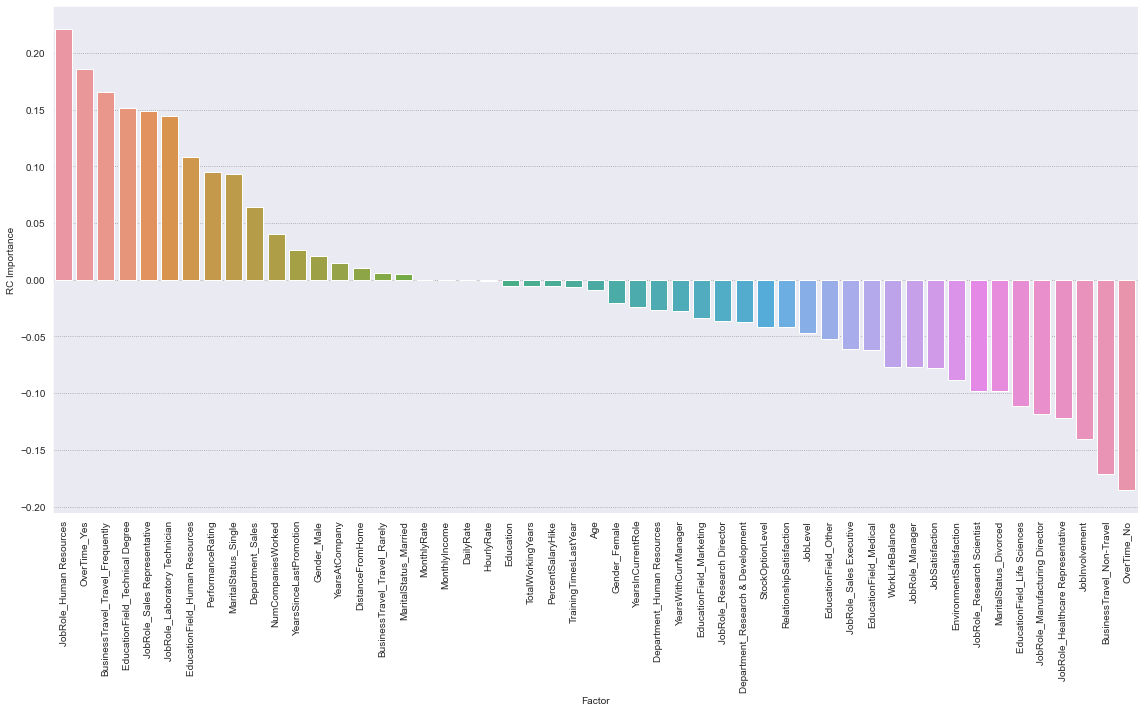

In [45]:
# let's graphically present the data
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.barplot(x='Factor', y='RC Importance', data=linear_factors)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('linear.png')

So, these are the results of our first model. The most obvious disadvantage is noticed right away: it is the fact that model focuses on specific features of a person (as `JobRole`, `EducationField` or `Department`) rather than common features (e.g.`OverTime`, `EnvironmentSatisfaction`). So, if we have a different group of employees where there's no `Sales Representatives` or `Human Resources` present, the model will struggle.
Nevertheless, we have some facts that are intuitively true: e.g., employees who work overtime (`OverTime_Yes`) or travel frequently (`BusinessTravel_Travel_Frequently`) are more likely to get attrited and vice versa (more detailed analysis $-$ in the presentation attached).

Now let's move to two ensemble models.

### Ensemble model: Random Forest Classifier

In [20]:
# same steps here
results_rf_acc = []
results_rf_f1 = []
test_sizes = np.arange(0.05, 0.51, 0.05)
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    random_forest = RandomForestClassifier(n_estimators=100)
    rf_model = random_forest.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    results_rf_acc.append(eval_acc(random_forest, X_test, y_test)[0])
    results_rf_f1.append(eval_acc(random_forest, X_test, y_test)[1])

Mean accuracy for Ridge Classifier is 0.86
Mean F1-score for Ridge Classifier is 0.82
Accuracy: 0.8585034013605443
f1-score: 0.8217142857142857
[[608   8]
 [ 96  23]]
              precision    recall  f1-score   support

          -1       0.86      0.99      0.92       616
           1       0.74      0.19      0.31       119

    accuracy                           0.86       735
   macro avg       0.80      0.59      0.61       735
weighted avg       0.84      0.86      0.82       735



(0.8585034013605443, 0.8217142857142857)

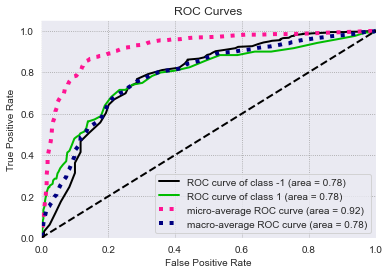

In [21]:
# let's find the mean accuracy and f1-score and look at extended parameters of last launch, including ROC Curves
print('=' * 50)
print('Mean accuracy for Ridge Classifier is %.2f' % np.mean(results_rf_acc))
print('Mean F1-score for Ridge Classifier is %.2f' % np.mean(results_rf_f1))
print('=' * 50)
eval_acc(random_forest, X_test, y_test, 1)

The results are quite the same, now again let's look at each feature and its importance.

### Random Forest Classifier Results

Luckily we have a `feature importances` method here, so it is easier 

In [22]:
feature_importance_rf = list(zip(columns_list, rf_model.feature_importances_))
feature_importance_rf_df = pd.DataFrame(feature_importance_rf,
columns=['Factor', 'RF Importance'])
feature_importance_rf_df.sort_values('RF Importance', ascending=False, inplace=True)
feature_importance_rf_df

,Factor,RF Importance
9,MonthlyIncome,0.071531
0,Age,0.069421
10,MonthlyRate,0.049223
1,DailyRate,0.048001
5,HourlyRate,0.045273
2,DistanceFromHome,0.045047
16,TotalWorkingYears,0.044821
49,OverTime_No,0.041779
50,OverTime_Yes,0.040514
19,YearsAtCompany,0.037514


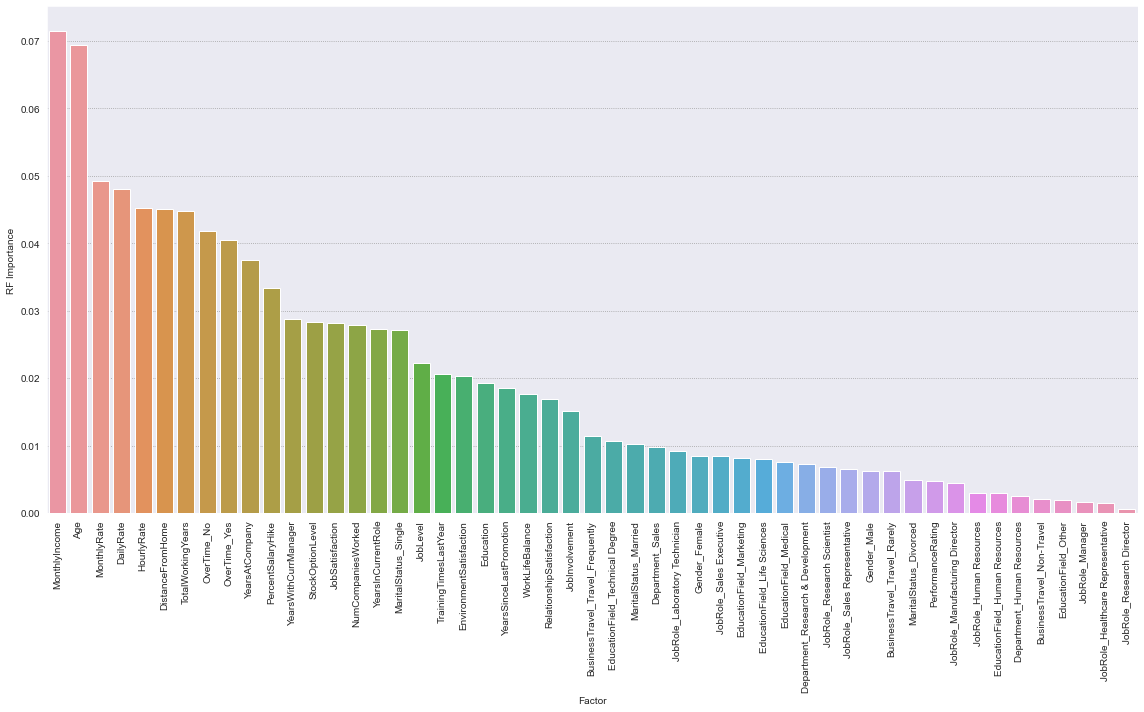

In [46]:
# let's graphically present the data
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.barplot(x='Factor', y='RF Importance', data=feature_importance_rf_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('rf_ensemble.png')

As we see, this model don't have the disadvantage of its predecessor: we clearly see that the most crucial factors are quite common: like `Age`, `Monthly Income` and `Rates`. 

### Ensemble model: Gradient Boosting Classifier

In [24]:
# same story
results_gb_acc = []
results_gb_f1 = []
test_sizes = np.arange(0.05, 0.51, 0.05)
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    gradient_boosting = GradientBoostingClassifier(n_estimators=100)
    gb_model = gradient_boosting.fit(X_train, y_train)
    predictions = gb_model.predict(X_test)
    results_gb_acc.append(eval_acc(gradient_boosting, X_test, y_test)[0])
    results_gb_f1.append(eval_acc(gradient_boosting, X_test, y_test)[1])

Mean accuracy for Gradient Boosting is 0.86
Mean F1-score for Gradient Boosting is 0.82
Accuracy: 0.8721088435374149
f1-score: 0.8495658171102543
[[604  13]
 [ 81  37]]
              precision    recall  f1-score   support

          -1       0.88      0.98      0.93       617
           1       0.74      0.31      0.44       118

    accuracy                           0.87       735
   macro avg       0.81      0.65      0.68       735
weighted avg       0.86      0.87      0.85       735



(0.8721088435374149, 0.8495658171102543)

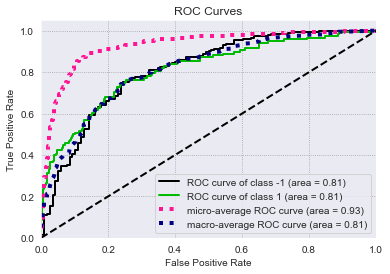

In [25]:
# let's find the mean accuracy and f1-score and look at extended parameters of last launch, including ROC Curves
print('=' * 50)
print('Mean accuracy for Gradient Boosting is %.2f' % np.mean(results_rf_acc))
print('Mean F1-score for Gradient Boosting is %.2f' % np.mean(results_rf_f1))
print('=' * 50)
eval_acc(gradient_boosting, X_test, y_test, 1)

Almost identical to previous. Now to the features:

In [26]:
feature_importance_gb = list(zip(columns_list, gb_model.feature_importances_))
feature_importance_gb_df = pd.DataFrame(feature_importance_gb, columns=['Factor', 'GB Importance'])
feature_importance_gb_df.sort_values('GB Importance', ascending=False, inplace=True)
feature_importance_gb_df

,Factor,GB Importance
9,MonthlyIncome,0.121379
1,DailyRate,0.085137
0,Age,0.080370
19,YearsAtCompany,0.056511
4,EnvironmentSatisfaction,0.054483
15,StockOptionLevel,0.046981
49,OverTime_No,0.044310
10,MonthlyRate,0.032857
12,PercentSalaryHike,0.032708
50,OverTime_Yes,0.031332


And visualization:

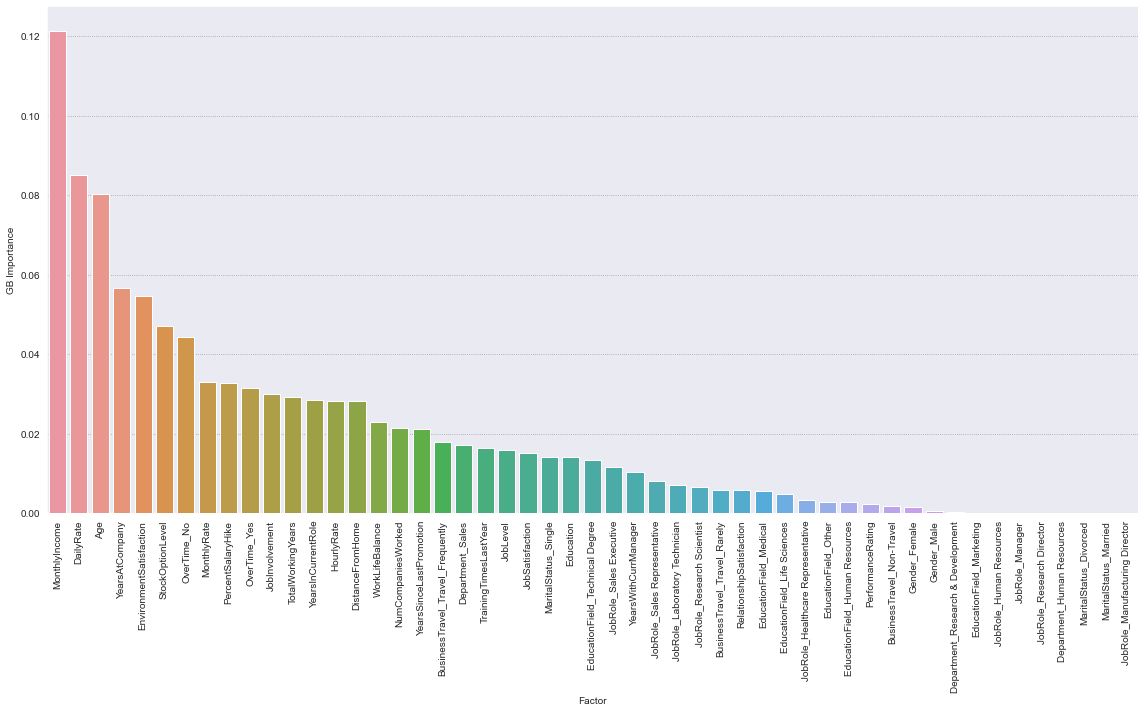

In [47]:
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.barplot(x='Factor', y='GB Importance', data=feature_importance_gb_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('gb_ensemble.png')

Now let's use an heuristic approach: since our two emsemble models showed quite similar results in terms of both accuracy metrics and feature importances, let's visualize the mean distribution of feature importances.

In [28]:
# merge two dataframes (feature_importance_gb_df, feature_importance_rf_df) based on 'Factor'
rf_gb_importance = pd.merge(feature_importance_rf_df, feature_importance_gb_df, on='Factor')
rf_gb_importance['Mean Importance'] = rf_gb_importance[['RF Importance', 'GB Importance']].mean(axis=1)
rf_gb_importance.sort_values('Mean Importance', axis=0, ascending=False, inplace=True)

In [29]:
# let's look at the Mean Importance
rf_gb_importance

,Factor,RF Importance,GB Importance,Mean Importance
0,MonthlyIncome,0.071531,0.121379,0.096455
1,Age,0.069421,0.080370,0.074896
3,DailyRate,0.048001,0.085137,0.066569
9,YearsAtCompany,0.037514,0.056511,0.047013
7,OverTime_No,0.041779,0.044310,0.043045
2,MonthlyRate,0.049223,0.032857,0.041040
12,StockOptionLevel,0.028381,0.046981,0.037681
19,EnvironmentSatisfaction,0.020343,0.054483,0.037413
6,TotalWorkingYears,0.044821,0.029278,0.037049
4,HourlyRate,0.045273,0.028110,0.036691


And resulted visualization:

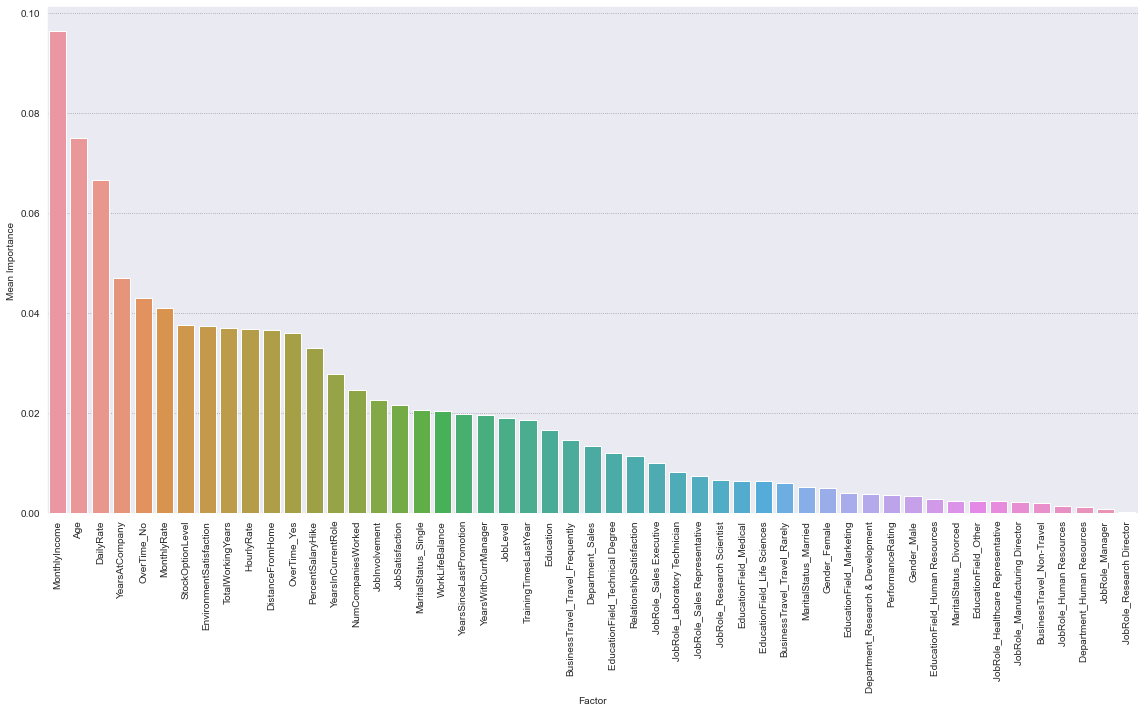

In [48]:
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.barplot(x='Factor', y='Mean Importance', data=rf_gb_importance)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('common_ensemble.png')

Here, as you can see, we obtained a more 'leveled' or stair-like graph, that enables us to prioritize factors a bit more precisely: e.g., the top three factors with a solid margin are `MonthlyIncome`, `Age` and `DailyRate`, then goes the group of `YearsAtCompany`, `OverTime_No` and `MonthlyRate`. Finally, the third impactful group consists of `EnvironmentSatisfaction`, `StockOptionLevel`, `TotalWorkingYears`, `DistanceFromHome` and `OverTime_Yes`.

Now, finally, let's examine the last method.

### Cat Boost Classifier

Even though Cat Boost Classifier is also an ensemble model, it's a much more advanced model due to the use of oblivious decision trees. This method is developed by Yandex and is widely used in industry.

In [31]:
# here we'll use the Pipeline for fun

cat_standard_pipe = Pipeline(steps=[
                                    ("scaler", StandardScaler()), 
                                    ("catboost", CatBoostClassifier(verbose=False)),
                                    ])
results_cb_acc = []
results_cb_f1 = []
test_sizes = np.arange(0.05, 0.51, 0.05)
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    cat_standard_pipe.fit(X_train, y_train)
    results_cb_acc.append(eval_acc(cat_standard_pipe.named_steps['catboost'], X_test, y_test)[0])
    results_cb_f1.append(eval_acc(cat_standard_pipe.named_steps['catboost'], X_test, y_test)[1])

Mean accuracy for Cat Boost Classifier is 0.86
Mean F1-score for Cat Boost Classifier is 0.82
Accuracy: 0.927891156462585
f1-score: 0.9215486629293895
[[610   6]
 [ 47  72]]
              precision    recall  f1-score   support

          -1       0.93      0.99      0.96       616
           1       0.92      0.61      0.73       119

    accuracy                           0.93       735
   macro avg       0.93      0.80      0.84       735
weighted avg       0.93      0.93      0.92       735



(0.927891156462585, 0.9215486629293895)

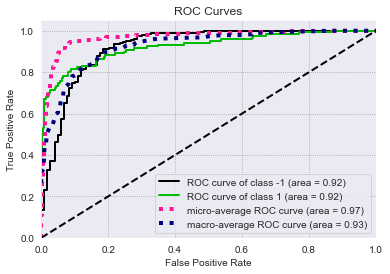

In [32]:
# let's find the mean accuracy and f1-score and look at extended parameters of last launch, including ROC Curves
print('=' * 50)
print('Mean accuracy for Cat Boost Classifier is %.2f' % np.mean(results_rf_acc))
print('Mean F1-score for Cat Boost Classifier is %.2f' % np.mean(results_rf_f1))
print('=' * 50)
eval_acc(gradient_boosting, X_test, y_test, 1)

As we see, the metrics for this model is better. Unsurprisingly - this is a 'heavier' method and a more advanced one.

Now, for the last time, visualization:

In [33]:
fimportances = cat_standard_pipe.named_steps['catboost'].feature_importances_

feature_importance_cb = list(zip(columns_list, fimportances))
feature_importance_cb_df = pd.DataFrame(feature_importance_cb, columns=['Factor', 'CB Importance'])
feature_importance_cb_df.sort_values('CB Importance', ascending=False, inplace=True)
feature_importance_cb_df

,Factor,CB Importance
0,Age,6.639480
4,EnvironmentSatisfaction,4.795880
2,DistanceFromHome,4.527183
15,StockOptionLevel,4.283335
49,OverTime_No,4.136625
9,MonthlyIncome,4.087079
8,JobSatisfaction,3.943899
50,OverTime_Yes,3.752408
5,HourlyRate,3.580747
7,JobLevel,3.496010


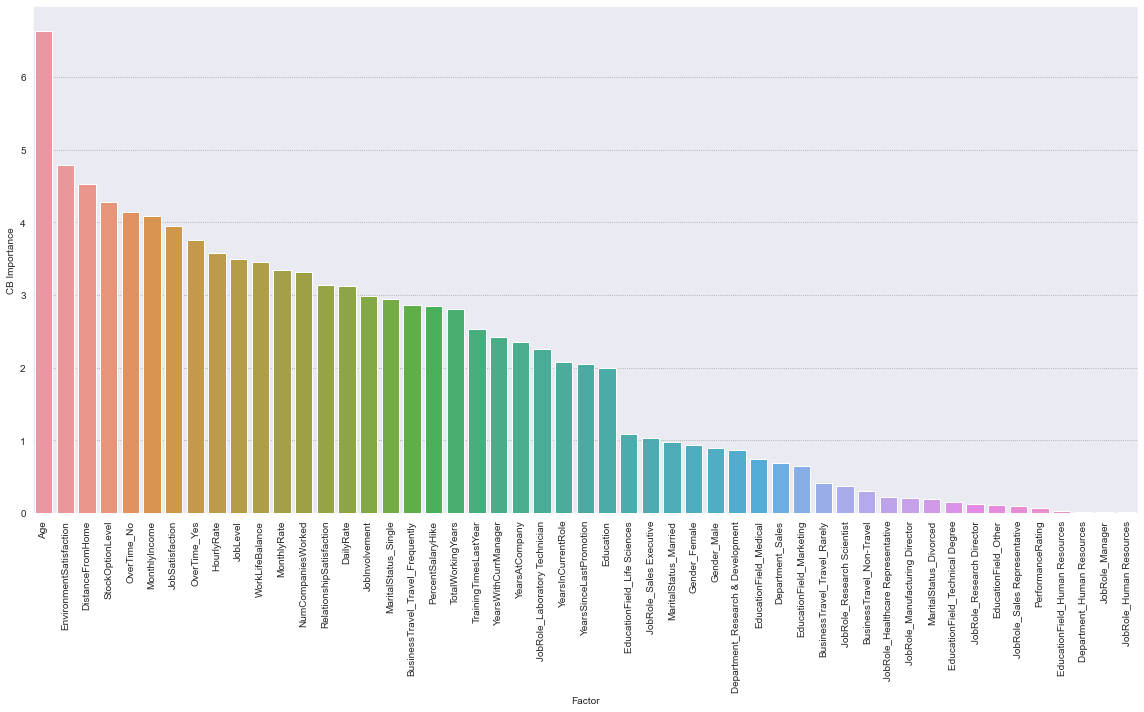

In [49]:
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.barplot(x='Factor', y='CB Importance', data=feature_importance_cb_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('catboost.png')

The overall conclusion is given in the presentation. Enjoy!

## THE END